In [2]:
#importing cell
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pysindy as ps
# numerical differentiation
from scipy.misc import derivative

# PySINDy

We will first deploy the package `PySINDy` developed by the authors to perform the PDE-FIND method on our generated data.

The <a href=https://pysindy.readthedocs.io/en/latest/index.html#>documentation</a> provides a basic description of the package's workflow: it revolves around the use of the `SINDy` object that performs the regression task and consists of three basic components, one for each crucial step of the algorithm:

1. `differentiation_method`: determines the computation of the derivatives, but it's possible to supply them manually
2. `feature_library`: this determines the library the algorithm will use to try and guess the underlying PDE
3. `optimizer`: implements the actual sparse regression algorithm

The `SINDy` object has a similar syntax to `sklearn`'s model objects (it was written with `sklearn` compatibility in mind) and is capable of using the SINDy results to, for instance, evolve a different initial condition, or to predict derivatives, and much more.

Let's use this to try and retrieve the original Lorenz system from the snapshots of its simulated dynamics. First things first, we load up the data:

In [3]:
# load data
r = np.load("./data/lorenz_r.npy")
r_noisy= np.load("./data/lorenz_r_noisy.npy")
t = np.load("./data/lorenz_t.npy")

# r is shaped like (n_points,n_dimensions)
print("Data vector:")
print(r[:5])

# t is time axis
print("\n\nTime vector:")
print(t[:5])

Data vector:
[[1.         1.         1.        ]
 [1.01256821 1.2599461  0.98488969]
 [1.04883096 1.52405449 0.97311235]
 [1.10722704 1.79839899 0.96515735]
 [1.18690156 2.08866556 0.96173704]]


Time vector:
[0.       0.010001 0.020002 0.030003 0.040004]


Then we instantiate a `SINDy` model object. 

In order to do that, we will need to first specify an `optimizer` object that will operate the regression: the <a href=https://pysindy.readthedocs.io/en/latest/api/pysindy.optimizers.html>documentation</a> again provides an exhaustive description of the available optimizer algorithms. For now, we will simply let the model default to STLSQ submodule, which performs a sequentially thresholded least squares algorithm, i.e. minimizes the loss $||y- Xw ||^2 + \alpha ||w||_2 ^2$ by performing iteratively a least squares regression followed by a mask application that filters out $w$ coefficients whose magnitude lies under a certain threshold. This is the main algorithm suggested in the author's paper and it defaults to a ridge regression (with L2 norm, as opposed to Lasso regression).

Then, we need to define the features library, that is the subspace of possible derivatives combinations we wish to explore to find those that are the most informative about our system's evolution. Again, PySINDy provides a variety of different submodules, and the default one that is called when instantiating the model is `PolynomialLibrary`

In [4]:
# missing pieces


feature_names = ['x','y','z'] # just a label for the features, instead of simply using x1,x2....

# default optimizer, library and differentiation method
model = ps.SINDy(feature_names=feature_names) 
# we could also specify t_default which would be the default time step, but this will be overwritten if 
# the discretized temporal axis (in our case the t array) is passed to the .fit() method

In [11]:
# the .fit() method also accepts pre-computed time derivatives via the argument x_dot

model.fit(r[:],t=t[:])

model.print()

(x)' = -9.977 x + 9.977 y
(y)' = 27.809 x + -0.963 y + -0.995 x z
(z)' = -2.659 z + 0.997 x y


Let's recall the definition of the Lorenz system we used to generate the data

$$
\begin{cases}
\dot{x} = \sigma(y-x) \\ 
\dot{y} = x(\rho - z) - y \\
\dot{z} = xy - \beta z
\end{cases}
$$

with the following parametrization:

$$
\begin{cases}
\sigma = 10 \\ 
\rho = 28 \\ 
\beta = \frac{8}{3}
\end{cases}
$$

So the algorithm works as intended; no surprise there, since this was one of the toy models that the authors provide as a benchmark for the `PySINDy` package. Let's go a step forward and try to simulate a new trajectory with the interpolated model, and compare it to the original:

In [9]:
r_sim = model.simulate(r[0],t) # evolve a system in time along a discrete axis t
np.save("./data/lorenz_r_sim.npy",r_sim)

The `.simulate()` method we just ran simply calls `odeint` and `solve_ivp` functions from `scipy.integrate` module to integrate the system it just found. 

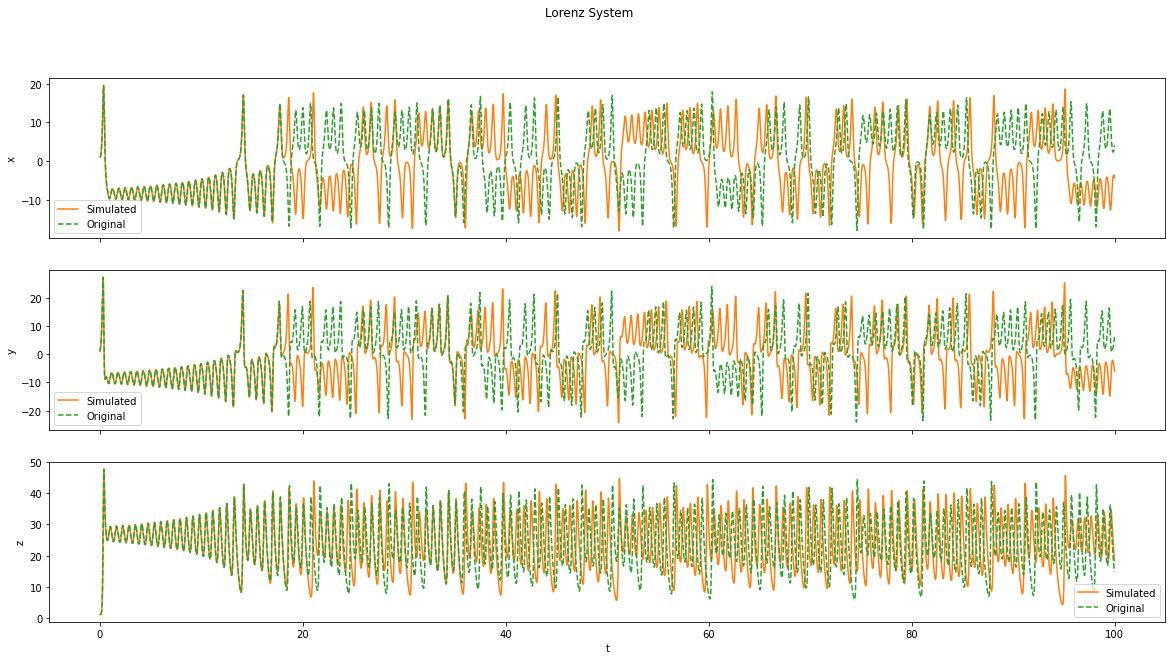

In [13]:
fig,axs = plt.subplots(3,1,figsize=[20,10],sharex=True)
fig.suptitle("Lorenz System")
for i in range(3):
    axs[i].set_ylabel(feature_names[i])
    axs[i].plot(t,r_sim[:,i],label='Simulated',color='C1')
    axs[i].plot(t,r[:,i],label='Original',linestyle='--',color="C2")
    axs[i].legend()
    if i==2: axs[i].set_xlabel("t")

plt.show()

As we can see, at some point the numerical error in the system of equations results in a slightly different trajectory that starts looping around the opposite lobe at some point. We can see this better with an animation:

In [22]:
if './img/lorenz_sim_vs_orig.gif' not in glob.glob('./img/*'): # only run if animation wasnt rendered already because it takes some time
    %run animate_lorenz_sim_vs_orig.py

<img src='./img/lorenz_sim_vs_orig.gif'>